**Customer Behavior Analysis using Unsupervised Learning**

imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [ ]:
df = pd.read_csv("data.csv", encoding='latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.shape


(541909, 8)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]


In [ ]:
df.isna().sum()


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
df.duplicated().sum()

np.int64(5192)

In [ ]:
df = df.drop_duplicates()
print("After cleaning:", df.shape)


After cleaning: (392692, 8)


In [ ]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Quantity,392692.0,13.119702,180.492832,1.000,2.00,6.00,12.00,80995.00
UnitPrice,392692.0,3.125914,22.241836,0.001,1.25,1.95,3.75,8142.75
CustomerID,392692.0,15287.843865,1713.539549,12346.000,13955.00,15150.00,16791.00,18287.00


Features related to purchases and payments show strong correlations, indicating potential customer spending patterns.

**Scaling before Clustering**
Becuase Kmeans-DBSCAN depends on distancd

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm)


Handling nuallity before PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Impute NaN values in X_scaled if any are still present
imputer = SimpleImputer(strategy='median')
X_scaled_imputed = imputer.fit_transform(X_scaled)

pca = PCA(n_components=0.90, random_state=42) # Changed to capture 90% variance
X_pca = pca.fit_transform(X_scaled_imputed)

X_pca.shape

(4338, 3)

3 Columns
pc1,pc2,pc3

Simple plot

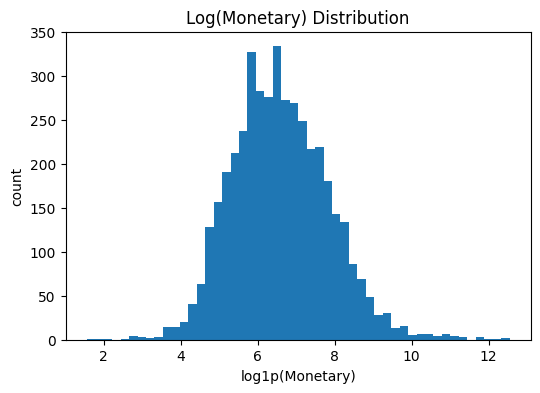

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(np.log1p(rfm["Monetary"]), bins=50)
plt.title("Log(Monetary) Distribution")
plt.xlabel("log1p(Monetary)")
plt.ylabel("count")
plt.show()

Feature Engineering

convert date

In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [ ]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2011-12-10 12:50:00')

 create rfm per customer

In [ ]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                   # Frequency
    "UnitPrice": lambda x: (x * df.loc[x.index, 'Quantity']).sum() # Monetary
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
rfm.head(), rfm.shape

(   CustomerID  Recency  Frequency  Monetary
 0     12346.0      326          1  77183.60
 1     12347.0        2          7   4310.00
 2     12348.0       75          4   1797.24
 3     12349.0       19          1   1757.55
 4     12350.0      310          1    334.40,
 (4338, 4))

Handle outlier

In [ ]:
rfm_clean = rfm.copy()

for col in ["Recency","Frequency","Monetary"]:
    low = rfm_clean[col].quantile(0.01)
    high = rfm_clean[col].quantile(0.99)
    rfm_clean[col] = rfm_clean[col].clip(low, high)

rfm_clean[["Recency","Frequency","Monetary"]].describe()


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.500692,4.008760,1592.644234
std,99.914624,4.863497,2788.353651
min,1.000000,1.000000,52.200000
25%,18.000000,1.000000,306.482500
50%,51.000000,2.000000,668.570000
75%,142.000000,5.000000,1660.597500
max,369.000000,30.000000,19780.487800


scaling

In [ ]:
X_rfm = rfm_clean[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfm)

**kMEANS CHOOSE BEST K**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil
    print(f"K={k} → Silhouette={sil:.3f}")

best_k = max(sil_scores, key=sil_scores.get)
print("\nBest K:", best_k, "Best Silhouette:", sil_scores[best_k])



K=2 → Silhouette=0.660
K=3 → Silhouette=0.540
K=4 → Silhouette=0.535
K=5 → Silhouette=0.471
K=6 → Silhouette=0.447
K=7 → Silhouette=0.427
K=8 → Silhouette=0.425

Best K: 2 Best Silhouette: 0.6602822896450592


train final model

In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
kmeans_labels = kmeans.fit_predict(X_scaled)

print("Final KMeans Silhouette:", silhouette_score(X_scaled, kmeans_labels))


Final KMeans Silhouette: 0.6602822896450592


DBSCAN

In [ ]:
def try_dbscan(eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.mean(labels == -1)

    sil = None
    mask = labels != -1
    if n_clusters >= 2 and mask.sum() > 10:
        sil = silhouette_score(X_scaled[mask], labels[mask])

    return n_clusters, noise_ratio, sil

best = None

for eps in [0.3, 0.4, 0.5, 0.6, 0.7]:
    for ms in [5, 10, 15, 20]:
        n_clusters, noise, sil = try_dbscan(eps, ms)
        print(f"eps={eps}, min_samples={ms} → clusters={n_clusters}, noise={noise:.2%}, silhouette={sil}")


eps=0.3, min_samples=5 → clusters=8, noise=3.83%, silhouette=0.09761468230014084
eps=0.3, min_samples=10 → clusters=3, noise=6.04%, silhouette=0.5376298610440288
eps=0.3, min_samples=15 → clusters=2, noise=7.15%, silhouette=0.8361353961292559
eps=0.3, min_samples=20 → clusters=2, noise=7.93%, silhouette=0.8387676983990597
eps=0.4, min_samples=5 → clusters=5, noise=2.77%, silhouette=0.6564966884273497
eps=0.4, min_samples=10 → clusters=2, noise=4.17%, silhouette=0.8242248407016326
eps=0.4, min_samples=15 → clusters=2, noise=5.30%, silhouette=0.8306790410596545
eps=0.4, min_samples=20 → clusters=2, noise=5.88%, silhouette=0.8332454474725471
eps=0.5, min_samples=5 → clusters=7, noise=1.54%, silhouette=0.6805109759054614
eps=0.5, min_samples=10 → clusters=2, noise=2.79%, silhouette=0.8144278126922344
eps=0.5, min_samples=15 → clusters=2, noise=3.37%, silhouette=0.8189537498037008
eps=0.5, min_samples=20 → clusters=2, noise=4.10%, silhouette=0.8250861748716862
eps=0.6, min_samples=5 → clust

FINAL MODEL

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

dbscan = DBSCAN(eps=0.5, min_samples=10)
db_labels = dbscan.fit_predict(X_scaled)
#NUMBER OF CLUSTERS
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
noise_ratio = np.mean(db_labels == -1)

print("Number of clusters:", n_clusters)
print("Noise ratio:", noise_ratio)

# Silhouette (excluding noise)
mask = db_labels != -1
sil_db = silhouette_score(X_scaled[mask], db_labels[mask])
print("DBSCAN Silhouette:", sil_db)


Number of clusters: 2
Noise ratio: 0.02789303826648225
DBSCAN Silhouette: 0.8144278126922344


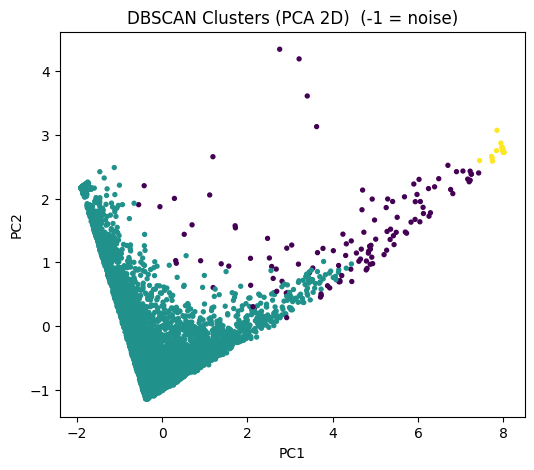

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=db_labels, s=8)
plt.title("DBSCAN Clusters (PCA 2D)  (-1 = noise)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


CLUSTER PROFILING

In [ ]:
rfm_result = rfm_clean.copy()
rfm_result["DBSCAN_Cluster"] = db_labels

#  REMOVE noise
profile = rfm_result[rfm_result["DBSCAN_Cluster"] != -1] \
    .groupby("DBSCAN_Cluster")[["Recency","Frequency","Monetary"]] \
    .mean()

profile


,Recency,Frequency,Monetary
DBSCAN_Cluster,,,
0,94.395415,3.429799,1190.975562
1,5.172414,29.689655,19740.716228


INSIGHTS

Cluster 0: High frequency & high monetary → VIP customers

Cluster 1: Low frequency & high recency → Inactive customers

Noise (-1): Irregular / rare buyers

**DBSCAN Results**

DBSCAN was applied on the RFM customer dataset after scaling.
The model successfully identified well-separated customer segments, achieving a Silhouette Score of 0.81, which indicates strong cluster separation.
A small percentage of customers were identified as noise, representing irregular purchasing behavior.

While K-Means provided reasonable segmentation, DBSCAN achieved superior cluster separation as measured by the Silhouette Score.